# **Numerical checks for the WongSolver**
In this notebook, we are going to perform various checks on our numerical routine for solving Wong's equations with Glasma background fields. 

## Conservation of Casimirs and modified Casimir scaling
The method used to solve the equation for the color charge, namely $Q(\tau)=U^\dagger_{\tau\rightarrow \tau_\mathrm{form}}Q(\tau_\mathrm{form})U_{\tau\rightarrow \tau_\mathrm{form}}$, with $U_{\tau\rightarrow \tau_\mathrm{form}}$ a very particular Wilson line constructed on the lattice, assures that $Q\in \mathrm{SU(N)}$ throughout the evolution and that the Casimir invariants are conserved. Any representation of $\mathrm{SU(2)}$ is labeled by a quadratic Casimir defined as $q_{2}=\sum\limits_a Q^aQ^a$. Its value is fixed according to $q_{2R}=D_R C_{2R}$ with $D_R$ denoting the dimension of the representation and $C_{2R}$ the group theory invariant in a given representation. For $\mathrm{SU}(3)$ there is also a cubic Casimir $q_{3}=\sum\limits_{abc}d_{abc}Q^aQ^bQ^c$ whose value is assigned as $q_{3R}=D_R C_{3R}$, where $C_{3R}$ is the standard cubic Casimir. This way of fixing the Casimirs $q_{2,3R}=D_R C_{2,3R}$ is taken from [Litim&Manuel2001](https://arxiv.org/abs/hep-ph/0110104). We check numerically that indeed their values are conserved.

The momentum broadening $\delta p_i^2$ extracted from Wong's equations exhibits a modified version of Casimir scaling, namely $\langle\delta p^2_i\rangle_A/\langle\delta p^2_i\rangle_F=q_{2A}/q_{2F}$, where $i=x,y,z$. Once the color charges are initialized in either the fundamental or adjoint representation, this scaling property is numerically checked.


### Default simulation parameters for the Glasma and the Wong solvers

Simulation parameters chosen for a Glasma characterized by a saturation momentum $Q_s=2\,\mathrm{GeV}$, in which the dynamics of infinitely massive heavy quarks is evolved numerically.

In [1]:
import numpy as np

# hbar * c [GeV * fm]
hbarc = 0.197326 

# Simulation box 
L = 10      
N = 512    
tau_sim = 2.0     
DTS = 8     

# Glasma fields
su_group = 'su3'
Qs = 2        
ns = 50    
factor = 0.8        
g2mu = Qs / factor     
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))          		
mu = g2mu / g**2          	
ir = 0.1 * g**2 * mu         
uv = 10.0           

# Wong solver 
mass = 10**5   
tau_form = 0   
pT = 0   
ntp = 10**5  
nevents = 5    
representation = 'fundamental'      
boundary = 'periodic'       

### Set environment variables

In [2]:
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["PRECISION"] = "double"
os.environ["GAUGE_GROUP"] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

# Wong modules
from curraun import wong
wong.BOUNDARY = boundary
wong.CASIMIRS = True
from curraun.wong import init_mom_toy, init_pos, init_charge

# Dictionary with parameters
p = {'representation' : representation}

Using CUDA
Using SU(3)
Using double precision
Using double precision


### Simulation routine for evolving the Glasma & solving Wong's equations
Computes the transverse and longitudinal momentum broadenings $\delta p_T^2$ and $\delta p_L^2$, along with the Casimirs of the color charges.

In [3]:
import pickle
from tqdm import tqdm

# Simulation routine
def simulate(p, ev): 
    representation = p["representation"]

    output = {}
    output["parameters"] = p.copy()

    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    formt = int(tau_form / a * DTS)
    maxt = int(tau_sim / a * DTS)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    # Initialize the Wong solver
    wong_solver = wong.WongSolver(s, ntp)
    x0s, p0s, q0s = np.zeros((ntp, 3)), np.zeros((ntp, 5)), np.zeros((ntp, su.ALGEBRA_ELEMENTS))
    masses = mass / E0 * np.ones(ntp)

    for i in range(ntp):
        x0, p0, q0 = init_pos(s.n), init_mom_toy('pT', pT / E0), init_charge(representation)
        x0s[i, :], p0s[i, :], q0s[i, :] = x0, p0, q0

    wong_solver.initialize(x0s, p0s, q0s, masses)

    mom_broad_T, mom_broad_L = np.zeros(maxt-formt), np.zeros(maxt-formt)
    casimirs = np.zeros((maxt-formt, ntp, su.CASIMIRS))

    with tqdm(total=maxt) as pbar:
        for t in range(maxt):
            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            # Solve Wong's equations
            if t>=formt:  
                mom_broad = wong_solver.p_sq_mean 
                mom_broad_T[t-formt] = (mom_broad[0] + mom_broad[1]) * E0**2
                mom_broad_L[t-formt] = mom_broad[2] * E0**2

                wong_solver.evolve()
                wong_solver.compute_mom_broad()

                wong_solver.compute_casimirs(representation)
                casimirs[t-formt] = wong_solver.c.copy()

            pbar.set_description("Event " + str(ev+1))
            pbar.update(1)

    output["mom_broad_T"], output["mom_broad_L"] = mom_broad_T, mom_broad_L
    output["casimirs"] = casimirs

    return output

### Running the Wong solver over multiple Glasma events

In [4]:
print(su_group[0:2].upper() + '(' + su_group[2] + ')' + ' gauge group')
representations = ['adjoint', 'fundamental']

mom_broad_T, mom_broad_L = {}, {}
casimirs = {}

for representation in representations:
    p["representation"] =  representation
    print(representation.capitalize() + ' representation')

    mom_broads_T, mom_broads_L = [], []
    for ev in range(nevents):
        output = simulate(p, ev)
        mom_broads_T.append(output["mom_broad_T"])
        mom_broads_L.append(output["mom_broad_L"])
        if ev==0:
            casimirs[representation] = output["casimirs"]

    mom_broad_T[representation] = np.mean(mom_broads_T, axis=0)
    mom_broad_L[representation] = np.mean(mom_broads_L, axis=0)

formt, maxt = int(tau_form / L * N * DTS), int(tau_sim / L * N * DTS)
tau = np.linspace(tau_form, tau_sim, maxt-formt)

output = {}
output["mom_broad_T"], output["mom_broad_L"], output["tau"] = mom_broad_T, mom_broad_L, tau
output["representations"] = representations
output["casimirs"] = casimirs

filename = 'casimir_scaling_' + su_group + '.pickle'
with open(filename, 'wb') as handle:
    pickle.dump(output, handle)

SU(3) gauge group
Adjoint representation


Event 5: 100%|██████████| 819/819 [04:41<00:00,  2.91it/s]


Fundamental representation


Event 5: 100%|██████████| 819/819 [04:41<00:00,  2.91it/s]


### Read data from files using Julia

In [2]:
using Pickle

su_groups = ["su2", "su3"]
results = Dict()
for su_group in su_groups
    results[su_group] = Pickle.npyload("casimir_scaling_" * su_group * ".pickle")
end
representations = results["su2"]["representations"]

2-element Vector{Any}:
 "adjoint"
 "fundamental"

In [3]:
hbarc = 0.197326 
Qs = 2

2

### Plot of Casimirs for the color charges as a function of proper time, using Makie from Julia

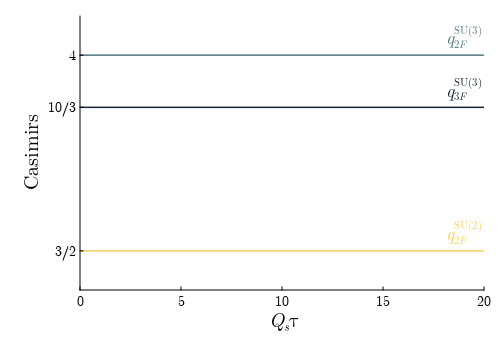

CairoScreen{Cairo.CairoSurfaceBase{UInt32}} with surface:
Cairo.CairoSurfaceBase{UInt32}(Ptr{Nothing} @0x000000002cb2b0d0, 2500.0, 1750.0)


In [101]:
using CairoMakie
using ColorSchemes

segmented_cmap = cgrad(:starrynight, 11, categorical = true)
colors = [segmented_cmap[11], segmented_cmap[4], segmented_cmap[1]]

fig = Figure(resolution = (500, 350), font = "CMU Serif")
ax = Axis(fig[1,1], xlabel=L"Q_s\tau", ylabel=L"\mathrm{Casimirs}",
        rightspinevisible = false, topspinevisible = false, xlabelsize = 20, ylabelsize= 20, xticklabelsize=14, yticklabelsize=14,
        xtickalign = 1, xticksize=4, ytickalign=1, yticksize=4, xlabelpadding = -5, xgridvisible = false, ygridvisible = false) 

tau = results["su2"]["tau"]
casimirs_su2 = results["su2"]["casimirs"]["fundamental"]
lines!(ax, tau*Qs/hbarc, casimirs_su2[:, 1], linewidth = 1.5, color=colors[1])
text!(ax, L"q_{2F}^\mathrm{SU(2)}", position = (18.2, 3/2+0.05), color=colors[1], textsize=18)

casimirs_su3 = results["su3"]["casimirs"]["fundamental"]
lines!(ax, tau*Qs/hbarc, casimirs_su3[:, 1, 1], linewidth = 1.5, color=colors[2])
text!(ax, L"q_{2F}^\mathrm{SU(3)}", position = (18.2, 4+0.05), color=colors[2], textsize=18)

lines!(ax, tau*Qs/hbarc, casimirs_su3[:, 1, 2], linewidth = 1.5, color=colors[3])
text!(ax, L"q_{3F}^\mathrm{SU(3)}", position = (18.2, 10/3+0.05), color=colors[3], textsize=18)

xlims!(ax, 0, 20)
ylims!(ax, 3/2-0.5, 4+0.5)
# ax.xticks = (0.5*(0:4), ["0", "0.5", "1", "1.5", "2"])
ax.yticks = ([3/2, 10/3, 4], ["3/2", "10/3", "4"])

display(fig)
save("makie_casimirs_su2+su3.png", fig, px_per_unit = 5.0) 

### Read data from files

In [ ]:
import pickle

su_groups = ['su2', 'su3']
results = {}
for su_group in su_groups:
    results[su_group] = pickle.load(open('casimir_scaling_' + su_group + '.pickle', 'rb'))
representations = results['su2']['representations']

### Plot of Casimirs for the color charges as a function of proper time

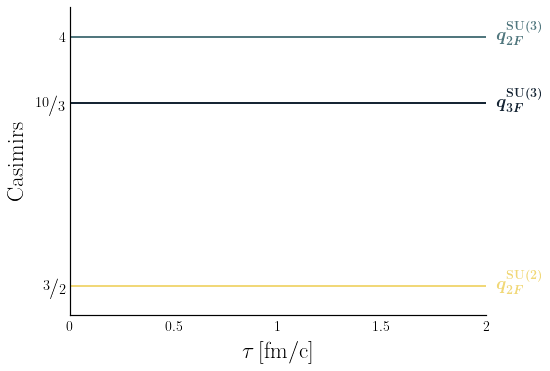

In [6]:
import matplotlib.pyplot as plt
plt.style.use('custom_style.mpltstyle')
plt.rcParams["figure.figsize"] = (8,5.5)
import matplotlib
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{xfrac}']

fig, ax = plt.subplots()

plt.ylabel(r'$\mathrm{Casimirs}$')
plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$')

labels = [r'$\mathrm{Adjoint}$', r'$\mathrm{Fundamental}$']
colors = ['#F1D878', '#51777E', '#162534']
linestyles = ['--', '-']

tau = results['su2']['tau']
casimirs_su2 = results['su2']['casimirs']
plt.plot(tau, casimirs_su2['fundamental'][:, 0], color=colors[0], linewidth = 2)
plt.text(2.05, 1.47, r'\boldmath$q_{2F}^\mathrm{SU(2)}$', fontsize=18, color=colors[0])

casimirs_su3 = results['su3']['casimirs']
plt.plot(tau, casimirs_su3['fundamental'][:, 0, 0], color=colors[1], linewidth = 2)
plt.text(2.05, 3.97, r'\boldmath$q_{2F}^\mathrm{SU(3)}$', fontsize=18, color=colors[1])

plt.plot(tau, casimirs_su3['fundamental'][:, 0, 1], color=colors[2], linewidth = 2)
plt.text(2.05, 3.3, r'\boldmath$q_{3F}^\mathrm{SU(3)}$', fontsize=18, color=colors[2])

ax.set_ylim(3/2-0.3, 4+0.3)
yticks = [3/2, 10/3, 4]
ax.set_yticks(yticks)
ylabels = [r'$\huge\sfrac{3}{\,2}$', r'$\huge\sfrac{10}{\,3}$', r'$4$']
ax.set_yticklabels(ylabels)

ax.set_xlim(0,2)
xticks = [0, 0.5, 1, 1.5, 2]
ax.set_xticks(xticks)
xlabels = [r'$0$', r'$0.5$', r'$1$', r'$1.5$', r'$2$']
ax.set_xticklabels(xlabels)

plt.tight_layout()
plt.savefig('final_casimirs_su2+su3.png', dpi=300, transparent=False, facecolor='white')

In [46]:
function string_as_varname(s::AbstractString,v::Any)
    s=Symbol(s)
    return @eval (($s) = ($v))
end

string_as_varname (generic function with 1 method)

### Plot of adjoint and fundamental representation transverse momentum broadenings and modified Casimir scaling, done in Makie from Julia

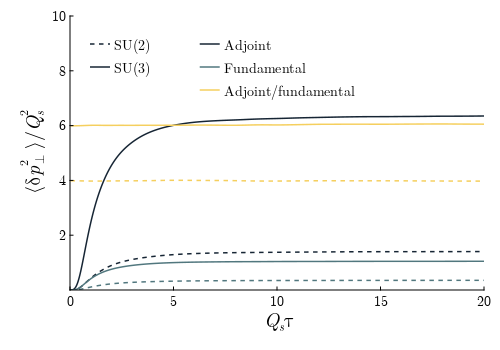

CairoScreen{Cairo.CairoSurfaceBase{UInt32}} with surface:
Cairo.CairoSurfaceBase{UInt32}(Ptr{Nothing} @0x000000002be06190, 2500.0, 1750.0)


In [98]:
fig = Figure(resolution = (500, 350), font = "CMU Serif")
ax = Axis(fig[1, 1], 
        xlabel=L"Q_s\tau", ylabel=L"\langle \delta p_\perp^2\,\rangle/ Q_s^2",
        rightspinevisible = false, topspinevisible = false, xlabelsize = 20, ylabelsize= 20, xticklabelsize=14, yticklabelsize=14,
        xtickalign = 1, xticksize=4, ytickalign=1, yticksize=4,  xlabelpadding = -5, xgridvisible = false, ygridvisible = false)

Ncs = [2, 3]
linestyles = [:dash, nothing]

for (i,su_group) in enumerate(su_groups)
        Nc = Ncs[i]
        Df, Da = Nc, Nc^2-1
        Cf, Ca = (Nc^2-1)/(2*Nc), Nc

        mom_broad_adj, mom_broad_fund = results[su_group]["mom_broad_T"]["adjoint"], results[su_group]["mom_broad_T"]["fundamental"]
        ratio = mom_broad_adj./mom_broad_fund
        tau = results[su_group]["tau"]

        string_as_varname(su_group*"_adj", lines!(ax, tau*Qs/hbarc, mom_broad_adj/Qs^2, linewidth = 1.5, color=colors[3], linestyle=linestyles[i]))
        string_as_varname(su_group*"_fund", lines!(ax, tau*Qs/hbarc, mom_broad_fund/Qs^2, linewidth = 1.5, color=colors[2], linestyle=linestyles[i]))
        string_as_varname(su_group*"_ratio", lines!(ax, tau*Qs/hbarc, ratio, linewidth = 1.5, color=colors[1], linestyle=linestyles[i]))
end

ylims!(ax, 0, 10)
xlims!(ax, 0, 20)
ax.yticks = ([2, 4, 6, 8, 10], ["2", "4", "6", "8", "10"])

legend_sugroup = [L"\mathrm{SU(2)}", L"\mathrm{SU(3)}"]
axislegend(ax, [su2_adj, su3_adj], legend_sugroup, labelsize=14, position = :lt, orientation = :vertical, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))

legend_repr = [L"\mathrm{Adjoint}", L"\mathrm{Fundamental}", L"\mathrm{Adjoint/fundamental}"]
axislegend(ax, [su3_adj, su3_fund, su3_ratio], legend_repr, labelsize=14, position = :ct, orientation = :vertical, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))

display(fig)
save("makie_casimir_scaling_su2+su3.png", fig, px_per_unit = 5.0) 

### Plot of adjoint and fundamental representation transverse momentum broadenings and modified Casimir scaling

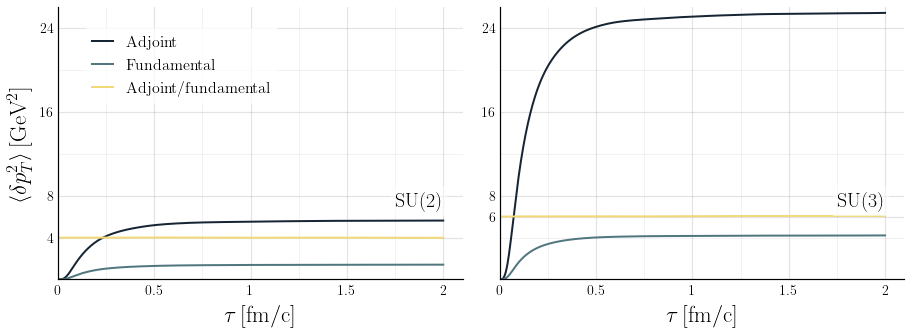

In [8]:
import matplotlib.pyplot as plt
import numpy as np 
from matplotlib.ticker import MultipleLocator

plt.style.use('custom_style.mpltstyle')
plt.rcParams["figure.figsize"] = (13,5)

fig, ax = plt.subplots(1, 2)

colors = ['#F1D878', '#51777E', '#162534']
ax[0].set_ylabel(r'$\langle \delta p_T^2\rangle\,\mathrm{[GeV^2]}$')

Ns = [2, 3]

for i, su_group in enumerate(su_groups):
    Nc = Ns[i]
    Df, Da = Nc, Nc**2-1
    Cf, Ca = (Nc**2-1)/(2*Nc), Nc

    sigmapt_adj, sigmapt_fund = results[su_group]['mom_broad_T']['adjoint'], results[su_group]['mom_broad_T']['fundamental']
    ratio = np.divide(sigmapt_adj, sigmapt_fund)
    tau = results[su_group]['tau']

    ax[i].plot(tau, sigmapt_adj,  label=r'$\mathrm{Adjoint}$', linewidth=2, color=colors[2])
    ax[i].plot(tau, sigmapt_fund, label=r'$\mathrm{Fundamental}$', linewidth=2, color=colors[1])
    ax[i].plot(tau, ratio, label=r'$\mathrm{Adjoint/fundamental}$', linewidth=2, color=colors[0])
    # ax[i].plot(tau, Ca*Da/(Cf*Df)*np.ones(tau.shape[0]), label=r'$\mathrm{Casimir\,scaling\,}q_{2A}/q_{2F}$', linestyle='--', color=colors[0], linewidth=2)

    ax[i].set_xlabel(r'$\tau\,\mathrm{[fm/c]}$')
    ax[i].set_ylim(0, 26)
    ax[i].set_xlim(0, 2.1)

    xticks = [0, 0.5, 1, 1.5, 2]
    ax[i].set_xticks(xticks)
    xlabels = [r'$0$', r'$0.5$', r'$1$', r'$1.5$', r'$2$']
    ax[i].set_xticklabels(xlabels) 

    ax[i].yaxis.set_major_locator(MultipleLocator(8))
    yticks = [2*Ns[i], 8, 16, 24]
    ax[i].set_yticks(yticks)
    ylabels = [r"${}$".format(str(2*Ns[i])), r'$8$', r'$16$', r'$24$']
    ax[i].set_yticklabels(ylabels) 

    ax[i].grid(visible=True, which='major', axis='both')

    ax[i].minorticks_on()
    ax[i].yaxis.set_minor_locator(MultipleLocator(4))
    ax[i].xaxis.set_minor_locator(MultipleLocator(0.25))
    ax[i].grid(visible=True, which='minor', axis='both', alpha=0.1, linewidth=0.9)

ax[0].legend(loc='upper left',bbox_to_anchor=(0.05,0.95))

t0 = ax[0].text(1.75, 7, r'$\mathrm{SU(2)}$', size=20)
t0.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))
t1 = ax[1].text(1.75, 7, r'$\mathrm{SU(3)}$', size=20)
t1.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))

plt.tight_layout()
plt.savefig('final_casimir_scaling_su2+su3.png', dpi=300, transparent=False, facecolor='white')

### Plot of $SU(3)$ vs. $SU(2)$ transverse momentum broadenings

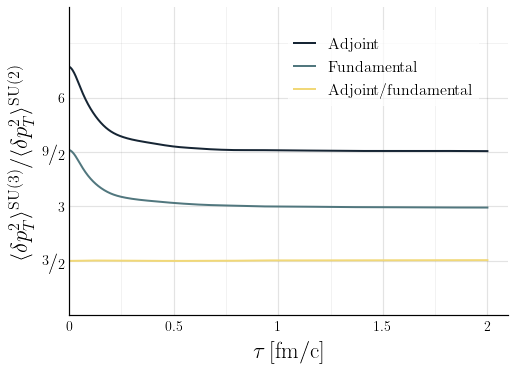

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MultipleLocator
import matplotlib
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{xfrac}']

plt.style.use('custom_style.mpltstyle')
plt.rcParams["figure.figsize"] = (7.5,5.5)

fig, ax = plt.subplots()

ax.set_ylabel(r'$\langle \delta p_T^2\rangle^\mathrm{SU(3)}/\langle \delta p_T^2\rangle^\mathrm{SU(2)}$')
ax.set_xlabel(r'$\tau\,\mathrm{[fm/c]}$')

Ns, labels = [2, 3], [r'$\mathrm{Adjoint}$', r'$\mathrm{Fundamental}$']
colors = ['#F1D878', '#51777E', '#162534']
color_indices = [2, 1]

ratio = {}
for i, representation in enumerate(representations):
    sigmapt_su2, sigmapt_su3 = results['su2']['mom_broad_T'][representation], results['su3']['mom_broad_T'][representation]
    ratio[representation] = np.divide(sigmapt_su3, sigmapt_su2)
    tau = results['su2']['tau']

    ax.plot(tau, ratio[representation], label=labels[i], linewidth = 2, color=colors[color_indices[i]])

ratio = np.divide(ratio['adjoint'], ratio['fundamental'])
ax.plot(tau, ratio, label=r'$\mathrm{Adjoint/fundamental}$', linewidth = 2, color=colors[0])

ax.set_ylim(0, 8.5)
ax.set_xlim(0, 2.1)

xticks = [0, 0.5, 1, 1.5, 2]
ax.set_xticks(xticks)
xlabels = [r'$0$', r'$0.5$', r'$1$', r'$1.5$', r'$2$']
ax.set_xticklabels(xlabels) 

ax.yaxis.set_major_locator(MultipleLocator(3))
yticks = [3/2, 3, 9/2, 6]
ax.set_yticks(yticks)
ylabels = [r'$\huge\sfrac{3}{\,2}$', r'$3$', r'$\huge\sfrac{9}{\,2}$', r'$6$']
ax.set_yticklabels(ylabels) 

ax.legend(loc='upper right',bbox_to_anchor=(0.95,0.95))

ax.minorticks_on()
ax.yaxis.set_minor_locator(MultipleLocator(1.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))
ax.grid(visible=True, which='major', axis='both')
ax.grid(visible=True, which='minor', axis='both', alpha=0.1, linewidth=0.9)

plt.tight_layout()
plt.savefig('final_mom_broad_ratio_su3_su2.png', dpi=300, transparent=False, facecolor='white')

### Plot of $SU(3)$ vs. $SU(2)$ transverse momentum broadenings, done in Makie from Julia

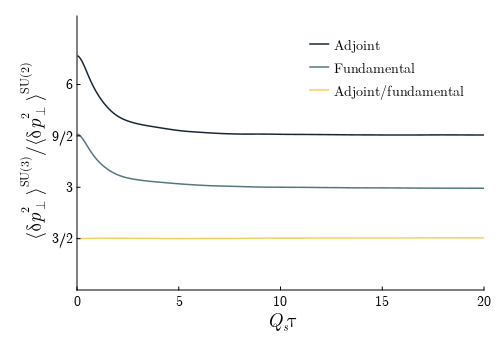

CairoScreen{Cairo.CairoSurfaceBase{UInt32}} with surface:
Cairo.CairoSurfaceBase{UInt32}(Ptr{Nothing} @0x000000002da8af70, 2500.0, 1750.0)


In [107]:
fig = Figure(resolution = (500, 350), font = "CMU Serif")
ax = Axis(fig[1, 1], 
        xlabel=L"Q_s\tau", ylabel=L"\langle \delta p_\perp^2\,\rangle^\mathrm{SU(3)}/\langle \delta p_\perp^2\,\rangle^\mathrm{SU(2)}",
        rightspinevisible = false, topspinevisible = false, xlabelsize = 20, ylabelsize= 20, xticklabelsize=14, yticklabelsize=14,
        xtickalign = 1, xticksize=4, ytickalign=1, yticksize=4,  xlabelpadding = -5, xgridvisible = false, ygridvisible = false)

colors = [segmented_cmap[1], segmented_cmap[4], segmented_cmap[11]]

ratio = Dict()
for (i, representation) in enumerate(representations)
        mom_broad_su2, mom_broad_su3 = results["su2"]["mom_broad_T"][representation], results["su3"]["mom_broad_T"][representation]
        ratio[representation] = mom_broad_su3./mom_broad_su2
        tau = results["su2"]["tau"]
        string_as_varname("ratio_"*representation, lines!(ax, tau*Qs/hbarc, ratio[representation], linewidth = 1.5, color=colors[i]))
end

ratios = ratio["adjoint"]./ratio["fundamental"]
string_as_varname("ratios", lines!(ax, tau*Qs/hbarc, ratios, linewidth = 1.5, color=colors[3]))

ylims!(ax, 0, 8)
xlims!(ax, 0, 20)
ax.yticks = ([3/2, 3, 9/2, 6], ["3/2", "3", "9/2", "6"])

legend_repr = [L"\mathrm{Adjoint}", L"\mathrm{Fundamental}", L"\mathrm{Adjoint/fundamental}"]
axislegend(ax, [ratio_adjoint, ratio_fundamental, ratios], legend_repr, labelsize=14, position = :rt, orientation = :vertical, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))

display(fig)
save("makie_ratio_su3_vs_su2.png", fig, px_per_unit = 5.0) 